# How we got to our final results

This notebook goes through the process of our participation in the AICrowd challenge _Road Segmentation_. The notebook should be seen as a complement to the final report. It should be noted that even though we compare models in this notebook, the comparisons are not perfect as considerably more time is spent optimizing hyperparameters for the UNet than for the other models. The notebook will focus on our most impactful insights, but also touch upon smaller stuff. The notebook do not contain all code necessary to generate the models, but rather imports some models we already have trained. To train our final model, please use the final_model.ipynb file instead.

The notebook contains the following sections:

* Import and Setup
* Validation set
* Logistic Regression
* Baseline CNN
    * Without data augmentation
    * With data augmentation
* UNet
    * UNet from scratch
    * UNet with the segmentation_models library
    * First version
    * With window predictions
    * Weight regularization
    * Doubling of the data augmentation
* Final ensemble model


## Imports and Setup

This section contains the essential setup and imports for the project

In [37]:
from baseline.helpers import *
import cv2
import numpy as np
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import segmentation_models as sm
sm.set_framework('tf.keras')
from seg_mod_unet.data_handling import extract_data, extract_data_test, extract_labels
from seg_mod_unet.helpers import patch_to_label, window_predict, img_float_to_uint8, save_predictions, test_threshold
from sklearn.metrics import f1_score, accuracy_score
import seaborn as sns

# Setting the style for plots using seaborn
sns.set()
sns.set_style("white")

## Validation set

To accurately determine the effect of our experiements, we define a testset which will be used for all models. The testset will be 10% of the data generated by the first data augmentation. All images here are of size 256x256. The code for creating this augmenation can be found in the augmentations.py file. It should be kept in mind that the final predictions will be done on 608x608 images so the results will not reflect the F1-score on AICrowd accurately. However, we experienced that the relative performance was generalizable, i.e. a model that performed better on this validation set performed better on AICrowd. The tests will be done patchwise as this is how the final performance is evaluated at AICrowd.

In [38]:
# path to groundtruth of test set
gt_path = 'data/training/groundtruth/10-split/'
files = os.listdir(gt_path)

# patch size equal to the one being used in AICrowd predictions
patch_size = 16

# defining threshold for converting patch to road
thr = 0.25

# saving each patch of groundtruth in the gts array
gts = []
for img in files:
    gt = mpimg.imread(os.path.join(gt_path, img))
    gt = np.expand_dims(gt[:,:,0], axis=2)
    for j in range(0, gt.shape[1], patch_size):
        for i in range(0, gt.shape[0], patch_size):
            patch = gt[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch, thr)
            gts.append(label)

In [ ]:
# Defining path for test images
val_dir = 'data/training/images/10-split'
# Extracting the validation data
val_images = extract_data(val_dir)

We do also define an image that will be used for visually inspecting predictions throughout the notebook.

In [17]:
# Defining path for one test image and its prediction
test_img_path = "data/training/images/10-split/satImage_095_Aug00.png"

# Reading the test image
test_img = mpimg.imread(test_img_path)

## Logistic Regression

The first model we implemented to start the project was a simple logistic regression. For the logistic regression, we extract 2-dimensional features consisting of average gray color as well as variance from the images. The features are then used to, patch-wise, predict whether a 16x16 patch is road or not. The model is trained on the original images.

__Data loading__

In [4]:
# Path to original images
image_path = str(Path.cwd()) + "/data/original/images/"

# Loading original images
files = os.listdir(image_path)
n = len(files) 
print("Loading " + str(n) + " original images")
imgs = [mpimg.imread(image_path + files[i]) for i in range(n)]

# Path to groundtruth images
gt_dir = str(Path.cwd()) + "/data/original/groundtruth/"
print("Loading " + str(n) + " groundtruth images")

# Loading groundtruth images
gt_imgs = []
for i in range (n):
    img = mpimg.imread(gt_dir + files[i])
    try:
        gt_imgs.append(img[:,:,0])
    except:
        gt_imgs.append(img)

Loading 100 original images
Loading 100 groundtruth images


__Feature processing__

In [5]:
# Defining patchsize to be 16*16 pixels
patch_size = 16 

# Extracting patches from the images
img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

# Percentage of pixels > 1 required to assign a foreground label to a patch
foreground_threshold = 0.25 

# Extracting features from patches
X = np.asarray([extract_features_2d(img_patches[i]) for i in range(len(img_patches))])

# Creating label list
Y = np.asarray([value_to_class(np.mean(gt_patches[i]), foreground_threshold) for i in range(len(gt_patches))])

In [6]:
# Splitting in training and test set
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle=False)

__Model__

In [7]:
# Creating logistic regression model
logreg = LogisticRegression(C=1e5, class_weight="balanced")
logreg.fit(x_train, y_train)

LogisticRegression(C=100000.0, class_weight='balanced')

In [8]:
# Predicting on test set
y_hat = logreg.predict(x_test)

# Calculating f1-score for the test set
f1 = f1_score(y_test, y_hat)

print(f'F1-Score: {f1}')

F1-Score: 0.43260988509939813


We see that the logistic regression achieves a F1-score of 0.43 on the test set. This is not especially good and supports the hypothesis that a more complex model is needed.

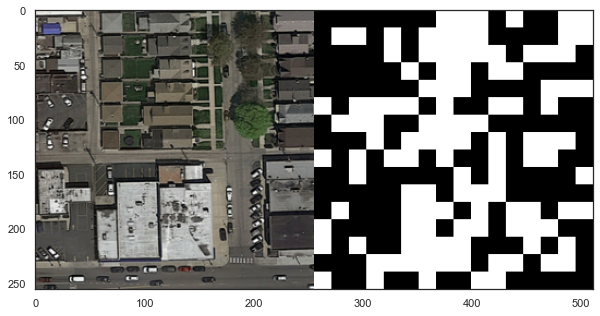

In [13]:
# Cropping test image to patches
test_patches = [img_crop(test_img, patch_size, patch_size)]

# Linearizing test images
test_patches = np.asarray([test_patches[i][j] for i in range(len(test_patches)) for j in range(len(test_patches[i]))])

# Extracting 2d features for test image
X_test = np.asarray([extract_features_2d(img_patches[i]) for i in range(len(img_patches))])

# Generating prediction on test image
pred = logreg.predict(X_test)

# converting prediction to image
pred_log = label_to_img(256, 256, patch_size, patch_size, pred)

# Visualizing original test image and prediction
cimg = concatenate_images(test_img, pred_log)
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

Moreover, from visualizing the image and our prediction, we observe that the model is not especially accurate. 

## Baseline CNN

As we noted above, the logistic regression was not particulary successful. We did therefore decide to implement an improved baseline model. This model is based upon the code given by the course which implements a basic CNN with two convolutional layers and two pooling layers. The code can be found in the file `baseline.py` in the baseline folder. More information about the model can be found in the report. All credits for the code is due Aurelien Lucchi from ETH Zürich, as we have only made minor modifications. 

First, we run the model on the original dataset. The arguments in the script below specify that the model should indeed be run on the original data.

In [1]:
%run "baseline/baseline.py" False

Running model without data augmentation
(62500, 2)
Number of data points per class: c0 = 46309 c1 = 16191
Balancing training data...
Number of data points per class: c0 = 16191 c1 = 16191
Initialized!
Total number of iterations = 15179
Epoch 0
Minibatch loss: 2.865, learning rate: 0.010000
Minibatch error: 60.9%
Model saved in file: /tmp/segment_aerial_images/model.ckpt
Epoch 1
Minibatch loss: 1.659, learning rate: 0.010000
Minibatch error: 34.4%
Model saved in file: /tmp/segment_aerial_images/model.ckpt
Epoch 2
Minibatch loss: 1.672, learning rate: 0.009500
Minibatch error: 42.2%
Model saved in file: /tmp/segment_aerial_images/model.ckpt
Epoch 3
Minibatch loss: 1.575, learning rate: 0.009025
Minibatch error: 34.4%
Model saved in file: /tmp/segment_aerial_images/model.ckpt
Epoch 4
Minibatch loss: 1.670, learning rate: 0.008574
Minibatch error: 45.3%
Model saved in file: /tmp/segment_aerial_images/model.ckpt
Epoch 5
Minibatch loss: 1.607, learning rate: 0.008145
Minibatch error: 35.9%
M

c:\Users\Benjamin\Desktop\Skole\EPFL\ml-project-2-vikings_ml\baseline\handling_images.py:186: RuntimeWarning: invalid value encountered in true_divide
  rimg = (rimg / np.max(rimg) * PIXEL_DEPTH).round().astype(np.uint8)


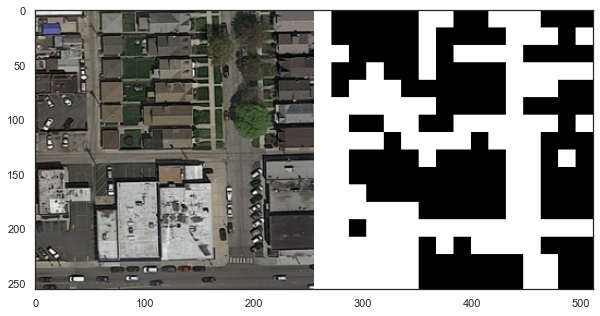

In [8]:
# Visualizing original test image and prediction
pred_cnn = mpimg.imread("predictions/69.png")
cimg = concatenate_images(test_img, pred_cnn)
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

We see that also the baseline CNN struggle with achieving any accuracy on the problem.

In [9]:
# Defining paths to save predictions and load groundtruths
pred_path = 'predictions/'
files = os.listdir(pred_path)

# Initializing lists for storing predictions and groundtruths
preds = []

# calculating patchwise predictions for all iamges in the test set
for i in range(len(files)):
    # Reading in predicted images
    pred = mpimg.imread(os.path.join(pred_path, '%d.png' % (i+1)))
    # converting prediction to patches
    for j in range(0, pred.shape[1], patch_size):
        for i in range(0, pred.shape[0], patch_size):
            patch = pred[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch, thr)
            preds.append(label)

# Calculating f1-score
f1 = f1_score(gts, preds)

print("The F1-score for the baseline CNN is %.3f"%f1)

The F1-score for the baseline CNN is 0.584


The F1-score for the model on the original data is 0.584. On AICrowd, it achieved a score of 0.598. To improve the predictions, we decided to apply feature agumentations. In the cells below, we run exactly the same model, but this time with feature augmentations. The augmentations are described in the report and the relevant setup is setup 1. This consists of in total 1700 images.

In [1]:
%run "baseline/baseline.py" True

Running model with data augmentation
(391680, 2)
Number of data points per class: c0 = 296228 c1 = 95452
Balancing training data...
Number of data points per class: c0 = 95452 c1 = 95452
Initialized!
Total number of iterations = 89486
Epoch 0
Minibatch loss: 2.656, learning rate: 0.010000
Minibatch error: 53.1%
Model saved in file: /tmp/segment_aerial_images/model.ckpt
Epoch 1
Minibatch loss: 1.561, learning rate: 0.010000
Minibatch error: 23.4%
Model saved in file: /tmp/segment_aerial_images/model.ckpt
Epoch 2
Minibatch loss: 1.588, learning rate: 0.009500
Minibatch error: 32.8%
Model saved in file: /tmp/segment_aerial_images/model.ckpt
Epoch 3
Minibatch loss: 1.537, learning rate: 0.009025
Minibatch error: 37.5%
Model saved in file: /tmp/segment_aerial_images/model.ckpt
Epoch 4
Minibatch loss: 1.522, learning rate: 0.008574
Minibatch error: 35.9%
Model saved in file: /tmp/segment_aerial_images/model.ckpt
Epoch 5
Minibatch loss: 1.355, learning rate: 0.008145
Minibatch error: 20.3%
Mo

c:\Users\Benjamin\Desktop\Skole\EPFL\ml-project-2-vikings_ml\baseline\handling_images.py:186: RuntimeWarning: invalid value encountered in true_divide
  rimg = (rimg / np.max(rimg) * PIXEL_DEPTH).round().astype(np.uint8)


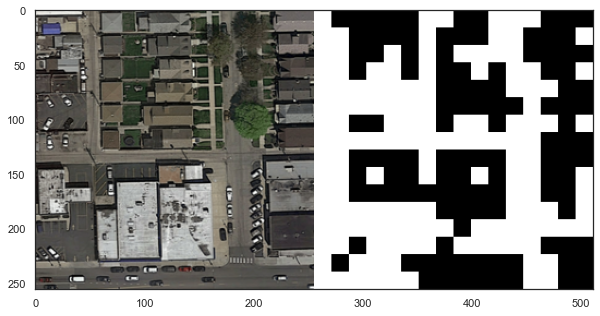

In [6]:
# Visualizing original test image and prediction
pred_cnn_aug = mpimg.imread("predictions/69.png")
cimg = concatenate_images(test_img, pred_cnn_aug)
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

From the image, it is hard to determine whether the model was improved through the data augmentation.

In [7]:
# Defining paths to save predictions and load groundtruths
pred_path = 'predictions/'
files = os.listdir(pred_path)

# Initializing lists for storing predictions and groundtruths
preds = []

# calculating patchwise predictions for all iamges in the test set
for i in range(len(files)):
    # Reading in predicted images
    pred = mpimg.imread(os.path.join(pred_path, '%d.png' % (i+1)))
    # converting prediction to patches
    for j in range(0, pred.shape[1], patch_size):
        for i in range(0, pred.shape[0], patch_size):
            patch = pred[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch, thr)
            preds.append(label)

# Calculating f1-score
f1 = f1_score(gts, preds)

print("The F1-score for the baseline CNN with feature augmentation is %.3f"%f1)

The F1-score for the baseline CNN with feature augmentation is 0.645


From the F1-score on the validation set, we observe that the data augmentation has improved the baseline CNN, as it now score a F1-score of 0.645. On AICrowd, it scores 0.688. This shows as research has suggested that data augmentation is an effective tool for dealing with training neural networks on datasets of limited size.

## UNet

The next major improvement we got was through the use of a UNet. A description of UNet can be found in our report. We did first implement the UNet from scratch, but we switched to utlize the `segmentation_models` library as it was easier to change architecture this way. The following section contains first our results from creating the model from scratch and then our `segmentation_models` implementation.

#### __UNet from scratch__

In [5]:
# loading the original UNet implementation
path_to_model = 'models/unet.h5'
model = load_model(path_to_model)

In [6]:
# predicting on validation images
results = model.predict(val_images)

# Generating and saving the prediction masks for the validation set
for i in range(1, len(results)+1):
  save_predictions(results[i-1], '%d'%i)

In [7]:
# Converting pixelwise predictions to patchwise predictions
y_pred_flattened = []
patch_size=16
thr = 0.13
for im in results:
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch, thr)
            y_pred_flattened.append(label)
y_pred_flattened = np.array(y_pred_flattened)

In [8]:
# Calculating f1-score
f1 = f1_score(gts, y_pred_flattened)

print("The F1-score for the original UNet is %.3f"%f1)

The F1-score for the original UNet is 0.764


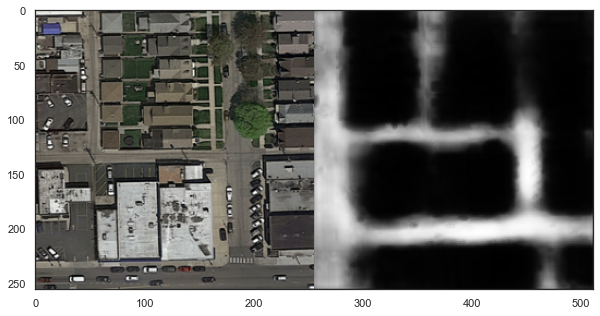

In [9]:
# visually inspecting the quality of prediction
#TODO: Fix the pred image
val_img = mpimg.imread("data/training/images/10-split/satImage_095_Aug00.png")
pred_unet = mpimg.imread("predictions/69.png")

# Visualizing original test image and prediction
cimg = concatenate_images(val_img, pred_unet)
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

### __Segmentation models UNet__

In this section, to avoid repeat ourselves, we have not included the code need to train the models and do load models from memory. The code for training can be found in the final_model.ipynb file. All of the models in this section can be trained from that file with minor modifications of hyperparameters or filepaths.

In [40]:
#TODO: SHould probably add something about the paramters the models are trained with for simplicity

In [8]:
# Defining backbone for the model
BACKBONE = 'resnet34'
# Downloading preprocessing function for the model
preprocess_input = sm.get_preprocessing(BACKBONE)
# Preprocessing the validation images for the backbone
val_images = preprocess_input(val_images)


#### __First implementation__

This model was our first implementation of UNet in the segmentation models library. Here, we introduced a 'resnet34' backbone to the model that we did not have in the from scratch implementation. This approach is more detailed in the report, but shortly, it uses residual blocks from a resnet34 in the encoder part of the UNet. 

In [27]:
# Loading the model
model = load_model('models/no_window.h5', custom_objects
                   = {'binary_crossentropy_plus_jaccard_loss':sm.losses.bce_jaccard_loss, 
                      'iou_score': sm.metrics.iou_score, 'f1-score': sm.metrics.FScore()})
                
# Generating predictions for the test images
results = model.predict(val_images)

# Generating and saving the prediction masks for the testset
for i in range(1, len(results)+1):
  save_predictions(results[i-1], '%d'%i)

# Converting pixelwise predictions to patchwise predictions by doing a grid search on which threshold that is best
patch_size=16
thrs = [0.01*i for i in range(30)]
best_thr = 0
best_f1 = 0
for thr in thrs:
    y_pred_flattened = []
    for im in results:
        for j in range(0, im.shape[1], patch_size):
            for i in range(0, im.shape[0], patch_size):
                patch = im[i:i + patch_size, j:j + patch_size]
                label = patch_to_label(patch, thr)
                y_pred_flattened.append(label)
    y_pred_flattened = np.array(y_pred_flattened)
    f1 = f1_score(gts, y_pred_flattened)
    if f1>best_f1:
        best_f1 = f1
        best_thr = thr

print("The F1-score for the UNet with resnet34 backbone without the window method is %.3f"%best_f1)

The F1-score for the UNet with resnet34 backbone and double data augmentation is 0.873


We see that the addition of a resnet34 backbone was effective and improved ur validation score from 0.764 to 0.873 and AICrowd score from 0.720 to 0.794. This shows the effectiveness of residual blocks.

In [41]:
#TODO: Add image that shows prediction

#### __Window method__

The train images in the dataset is 400x400 pixels while the test set is 608x608. As described in the report, we suspected that this made trobule in our models as we had to resize images up and down. Therefore, we implemented a window method to generate predictions. We did this through generating augmentations where all images were a random crop of size 256x256. The model is then trained on 256x256 images. For the prediction, we divide the test immage into 9 partially overlapping images and predict of each of these individually before assembling it back together. 

In [11]:
# Loading the first model as it is not trained on the validation set used in this notebook
model = load_model('models/no_reg.h5', custom_objects
                   = {'binary_crossentropy_plus_jaccard_loss':sm.losses.bce_jaccard_loss, 
                      'iou_score': sm.metrics.iou_score, 'f1-score': sm.metrics.FScore()})

# Generating predictions for the test images
results = model.predict(val_images)

# Generating and saving the prediction masks for the testset
for i in range(1, len(results)+1):
  save_predictions(results[i-1], '%d'%i)

# Converting pixelwise predictions to patchwise predictions by doing a grid search on which threshold that is best
patch_size=16
thrs = [0.01*i for i in range(30)]
best_thr = 0
best_f1 = 0
for thr in thrs:
    y_pred_flattened = []
    for im in results:
        for j in range(0, im.shape[1], patch_size):
            for i in range(0, im.shape[0], patch_size):
                patch = im[i:i + patch_size, j:j + patch_size]
                label = patch_to_label(patch, thr)
                y_pred_flattened.append(label)
    y_pred_flattened = np.array(y_pred_flattened)
    f1 = f1_score(gts, y_pred_flattened)
    if f1>best_f1:
        best_f1 = f1
        best_thr = thr

In [25]:
print("The F1-score for the UNet with resnet34 backbone and window predctions is %.3f"%best_f1)

The F1-score for the UNet with resnet34 backbone and no weight regularization is 0.975


As we can see, the predcitions improved substanially from 0.873 to 0.975. We observed the same improvement on AICrowd, going from 0.794 to 0.878. The reason for the higher scores on our validation set compared to AICrowd is probably that the local validation images are of size 256x256 while the images on AICrowd are 608x608 pixels. 

In [42]:
#TODO: Add image that shows prediction

#### __Weight regularization__

In [ ]:
# Loading the first model as it is not trained on the validation set used in this notebook
model = load_model('models/m1.h5', custom_objects
                   = {'binary_crossentropy_plus_jaccard_loss':sm.losses.bce_jaccard_loss, 
                      'iou_score': sm.metrics.iou_score, 'f1-score': sm.metrics.FScore()})

# Generating predictions for the test images
results = model.predict(val_images)

# Generating and saving the prediction masks for the testset
for i in range(1, len(results)+1):
  save_predictions(results[i-1], '%d'%i)  

# Converting pixelwise predictions to patchwise predictions by doing a grid search on which threshold that is best
patch_size=16
thrs = [0.01*i for i in range(30)]
best_thr = 0
best_f1 = 0
for thr in thrs:
    y_pred_flattened = []
    for im in results:
        for j in range(0, im.shape[1], patch_size):
            for i in range(0, im.shape[0], patch_size):
                patch = im[i:i + patch_size, j:j + patch_size]
                label = patch_to_label(patch, thr)
                y_pred_flattened.append(label)
    y_pred_flattened = np.array(y_pred_flattened)
    f1 = f1_score(gts, y_pred_flattened)
    if f1>best_f1:
        best_f1 = f1
        best_thr = thr            

In [63]:
print("The F1-score for the UNet with resnet34 backbone after introducing weight regularization is %.3f"%best_f1)

The F1-score for the UNet with resnet34 backbone is 0.983


We see that including a L2-norm weight regularizer with lambda=1 improved the validation score from 0.975 to 0.983 and on AICrowd from 0.878 to 0.886. This is a very slight improvement, but an improvement nonetheless. To determine the lambda value for the weight regularizer, we tried the values: 0.01, 0.1, 1, and 10. The difference between the values were very slight so we did not do any more accuracte optimization. 

Inspecting the prediction

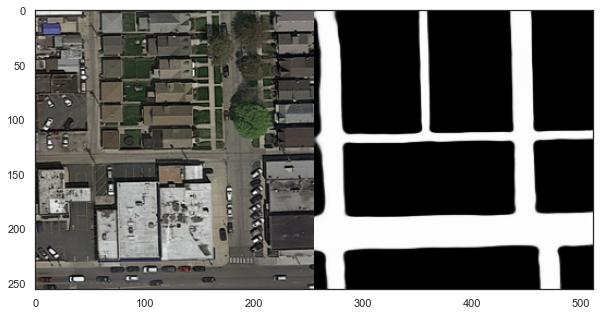

In [72]:
val_img = mpimg.imread("data/training/images/10-split/satImage_095_Aug00.png")
pred_unet = mpimg.imread("predictions/69.png")

# Visualizing original test image and prediction
cimg = concatenate_images(val_img, pred_unet)
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

#### __Doubling the data augmentation__

As the first data augmentation were very successful, we became intersted if further augmentation would improve our models. We did therefore try creating the UNet with a double data augmentation as described by setup 2 in the report. The results follow below:

In [26]:
# Loading the first model as it is not trained on the validation set used in this notebook
model = load_model('models/double.h5', custom_objects
                   = {'binary_crossentropy_plus_jaccard_loss':sm.losses.bce_jaccard_loss, 
                      'iou_score': sm.metrics.iou_score, 'f1-score': sm.metrics.FScore()})
                      
# Generating predictions for the test images
results = model.predict(val_images)

# Generating and saving the prediction masks for the testset
for i in range(1, len(results)+1):
  save_predictions(results[i-1], '%d'%i)

# Converting pixelwise predictions to patchwise predictions
patch_size=16
thrs = [0.01*i for i in range(30)]
best_thr = 0
best_f1 = 0
for thr in thrs:
    y_pred_flattened = []
    for im in results:
        for j in range(0, im.shape[1], patch_size):
            for i in range(0, im.shape[0], patch_size):
                patch = im[i:i + patch_size, j:j + patch_size]
                label = patch_to_label(patch, thr)
                y_pred_flattened.append(label)
    y_pred_flattened = np.array(y_pred_flattened)
    f1 = f1_score(gts, y_pred_flattened)
    if f1>best_f1:
        best_f1 = f1
        best_thr = thr

print("The F1-score for the UNet with resnet34 backbone and double data augmentation is %.3f"%best_f1)

The F1-score for the UNet with resnet34 backbone and double data augmentation is 0.839


Doubling the augmentations significantly weakened our predictions. We did therefore decide to stay on the original augmentation. A further improvement of the model could possibly be made by tweaking more on the number of augmentations parameter as we see it has a significant impact. It may even be that our original augmentation was too large.

#### __No data augmentation__

Finally, we wanted to assess how well the UNet performed without data augmentation, i.e. on the original dataset.

In [39]:
# Loading the first model as it is not trained on the validation set used in this notebook
model = load_model('models/simple.h5', custom_objects
                   = {'binary_crossentropy_plus_jaccard_loss':sm.losses.bce_jaccard_loss, 
                      'iou_score': sm.metrics.iou_score, 'f1-score': sm.metrics.FScore()})
                      
# Defining backbone for the model
BACKBONE = 'resnet34'

# Downloading preprocessing function for the model
preprocess_input = sm.get_preprocessing(BACKBONE)

# Defining path for test images
val_dir = os.path.join(os.path.join(str(Path.cwd()), 'data'), 'training') 
val_dir = os.path.join(os.path.join(val_dir, 'images'), '10-split/')

# Extracting the validation data
val_images = extract_data(val_dir)

# Preprocessing the validation images
val_images = preprocess_input(val_images)
# Generating predictions for the test images
results = model.predict(val_images)

# Generating and saving the prediction masks for the testset
for i in range(1, len(results)+1):
  save_predictions(results[i-1], '%d'%i)

# Converting pixelwise predictions to patchwise predictions
patch_size=16
thrs = [0.01*i for i in range(30)]
best_thr = 0
best_f1 = 0
for thr in thrs:
    y_pred_flattened = []
    for im in results:
        for j in range(0, im.shape[1], patch_size):
            for i in range(0, im.shape[0], patch_size):
                patch = im[i:i + patch_size, j:j + patch_size]
                label = patch_to_label(patch, thr)
                y_pred_flattened.append(label)
    y_pred_flattened = np.array(y_pred_flattened)
    f1 = f1_score(gts, y_pred_flattened)
    if f1>best_f1:
        best_f1 = f1
        best_thr = thr

print("The F1-score for the UNet with resnet34 backbone without data augmentation is %.3f"%best_f1)

The F1-score for the UNet with resnet34 backbone without data augmentation is 0.413


Withou data augmentation, we get a very weak F1-score. However, altough the results from this section indicates that the F1-score of UNet is doubled by introducing data augmentation, we do not want to conclude on this. We did not spend much time optimizing hyperparametrs so it may be that the performance could be improved significantly. The problem of the model withou data augmentation was that it overfitted greatly. On a pixelbasis during training, even after 200 epochs, it have a F1-score of 0.93 on the training data, but below 0.02 on the validation data. We tried including larger regularization but this had no effect. Other approaches for reducing overfitting like dropout could have been tried out to fix this.

But the conclusion is that there is no doubt that data augmentation is a very effective tool for improving perfromance when the original dataset is small.

## Ensemble

Finally, to improve our performance, we tried ensemble models. As outlined in the report, we tried several variants of ensembling, here we want to outline the main ones. All ensemble models consists of the predictions of 5 individual final UNets, from the codeblock above. The difference between the five models is that they each only had access to 4/5 of the dataset. This ensemble models is validated on the whole training set, not only the subset used earlier in the notebook. This is because under training, no data was set aside for testing, but all models had acces to 4/5 of the data in a 5-fold cross validation split. It shoul be kept in mind that this trainingset we validate on not is unknown to the models, so the test scores will not be perfectly generalizable.

In [44]:
# loading models
model_folder = os.path.join(str(Path.cwd()), 'models')
m1_path = os.path.join(model_folder, 'm1.h5')
m2_path = os.path.join(model_folder, 'm2.h5')
m3_path = os.path.join(model_folder, 'm3.h5')
m4_path = os.path.join(model_folder, 'm4.h5')
m5_path = os.path.join(model_folder, 'm5.h5')

# Custom objects for the model
custom_objects = {'binary_crossentropy_plus_jaccard_loss': sm.losses.bce_jaccard_loss,
                  'iou_score': sm.metrics.iou_score, 'f1-score': sm.metrics.FScore()}

# Loading models
print('Loading models')
m1 = load_model(m1_path, custom_objects=custom_objects)
m2 = load_model(m2_path, custom_objects=custom_objects)
m3 = load_model(m3_path, custom_objects=custom_objects)
m4 = load_model(m4_path, custom_objects=custom_objects)
m5 = load_model(m5_path, custom_objects=custom_objects)

models = [m1, m2, m3, m4, m5]
print('Loading test images')

# Loading test images
test_images = extract_data_test('data/training_final/images/')

Loading models
Loading test images


Generating predictions on the whole trainingset for each of the five individual models.

In [45]:
# Defining backbone for the model
BACKBONE = 'resnet34'
# Downloading preprocessing function for the model
preprocess_input = sm.get_preprocessing(BACKBONE)
# Preprocessing test images
test_images = preprocess_input(test_images)

for i in range(len(models)):
    # Generating predictions for the test images
    print('Predicting for model %i' % (i+1))
    results = models[i].predict(test_images)

    # Generating and saving the prediction masks for the testset
    for k in range(1, len(results)+1):
        save_predictions(results[k-1], '%d' % k)

    # Generating the prediction file for the test set
    submission_filename = 'predictions/m%d_pred_val.csv' % (i+1)
    image_filenames = []
    for j in range(1, 1701):
        image_filename = 'predictions/%d.png' % j
        image_filenames.append(image_filename)
    masks_to_submission(submission_filename,
                        0.25, *image_filenames)
    print("Finished predicting model %d\n" % (i+1))

Predicting for model 1


In [ ]:
X1 = 'predictions/m1_pred_val.csv'
X2 = 'predictions/m2_pred_val.csv'
X3 = 'predictions/m3_pred_val.csv'
X4 = 'predictions/m4_pred_val.csv'
X5 = 'predictions/m5_pred_val.csv'

In [ ]:
df1 = pd.read_csv(X1)
df1 = df1.set_index(['id'])
df1 = df1.rename({'prediction': 'p1'}, axis=1)

df2 = pd.read_csv(X2)
df2 = df2.set_index(['id'])
df2 = df2.rename({'prediction': 'p2'}, axis=1)

df3 = pd.read_csv(X3)
df3 = df3.set_index(['id'])
df3 = df3.rename({'prediction': 'p3'}, axis=1)

df4 = pd.read_csv(X4)
df4 = df4.set_index(['id'])
df4 = df4.rename({'prediction': 'p4'}, axis=1)

df5 = pd.read_csv(X5)
df5 = df5.set_index(['id'])
df5 = df5.rename({'prediction': 'p5'}, axis=1)

# Dataframe containing the prediction of all models for each patch
df = pd.concat([df1, df2, df3, df4, df5], axis=1)


In [ ]:
train, test = train_test_split(df, test_size = 0.2, random_state = 1)


# First generating the scores for the simple voting system
df_new = test.copy()
# Generating predictions, predicting road if all models predict road
for i in range(0,5):
    df_new['prediction%d'%i] = test.apply(lambda x: 1 if np.sum(x) > i else 0, axis=1)

In [ ]:
train.head()

In [34]:
# path to test set
gt_path = 'data/training_final/groundtruth/'
files = os.listdir(gt_path)

# patch size equal to the one being used in AICrowd predictions
patch_size = 16

# defining threshold for converting patch to road
thr = 0.25

# saving each patch of groundtruth in the gts array
gts = []
for img in files:
    gt = mpimg.imread(os.path.join(gt_path, img))
    gt = np.expand_dims(gt[:,:,0], axis=2)
    for j in range(0, gt.shape[1], patch_size):
        for i in range(0, gt.shape[0], patch_size):
            patch = gt[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch, thr)
            gts.append(label)

In [35]:
f1_scores = [f1_score(df_new['prediction%d'%i], gts) for i in range(0,5)]

for i in range(len(f1_scores)):
    print('F1-score for road if more than %d models say road: %.3f'%(i, f1_scores[i]))

F1-score for road if more than 0 models say road: 0.958
F1-score for road if more than 1 models say road: 0.980
F1-score for road if more than 2 models say road: 0.987
F1-score for road if more than 3 models say road: 0.986
F1-score for road if more than 4 models say road: 0.957


We see that the rule of voting road if more than 2 models say road is the best rule for the ensemble model on the training set. However, we tried all on AICrowd and found more than 4 too be best. The reason for this difference may be that this set on the validation set involves _data leakage_. 4 of 5 models have had access to the validation set during training and therefore, they have an advantage. Moreover, in this case, we predict on 256x256 images which are not entirley representable for the 608x608 images we predict for on AICrowd. We would therefore not put too much weight on this set.